In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import itertools
from collections import defaultdict
import math
import json
import xarray as xr
import glob 

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE

from src.embedding import Embedding
from src.environment import Rewards_env
from src.evaluations import evaluate, plot_eva
from src.regression import *
from src.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/users/u6015325/Solaris/synbio_rbs/sim_lit
['/home/users/u6015325/Solaris/synbio_rbs/sim_lit', '/localdata/u6015325/anaconda3/lib/python38.zip', '/localdata/u6015325/anaconda3/lib/python3.8', '/localdata/u6015325/anaconda3/lib/python3.8/lib-dynload', '', '/localdata/u6015325/anaconda3/lib/python3.8/site-packages', '/localdata/u6015325/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/home/users/u6015325/.ipython', '/home/users/u6015325/Solaris/synbio_rbs']


# Plot setting

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

rcParams['axes.labelsize'] = MEDIUM_SIZE # 15
rcParams['xtick.labelsize'] = SMALL_SIZE # 13
rcParams['ytick.labelsize'] = SMALL_SIZE # 13
rcParams['legend.fontsize'] = SMALL_SIZE # 13
rcParams['axes.titlesize'] = BIGGER_SIZE  # 15
# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = ['Computer Modern Roman']
# rcParams['text.usetex'] = True

# set color
# https://www.thinkingondata.com/something-about-viridis-library/
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
color_dict = {}

viridis = cm.get_cmap('viridis', 20)
tab10 = cm.get_cmap('tab20', 20)

# color_dict['Consensus'] = tab10.colors[0]
# color_dict['Reference'] = tab10.colors[6]
# color_dict['BPS-C'] = tab10.colors[14]
# color_dict['BPS-NC'] = tab10.colors[12]
color_dict['UNI'] = tab10.colors[10]
# color_dict['PPM'] = tab10.colors[11]

# color_dict['Bandit-0'] = viridis.colors[0]
# color_dict['Bandit-1'] = viridis.colors[1]
# color_dict['Bandit-2'] = viridis.colors[2]
# color_dict['Bandit-3'] = viridis.colors[3]

color_dict['Bandit-0'] = viridis.colors[3]
color_dict['Bandit-1'] = viridis.colors[8]
color_dict['Bandit-2'] = viridis.colors[13]
color_dict['Bandit-3'] = viridis.colors[18]

color_dict['Unlabeled'] = tab10.colors[15]
color_dict['Random'] = tab10.colors[10]

bandit_color_dict = {}

bandit_color_dict['Bandit-0'] = viridis.colors[3]
bandit_color_dict['Bandit-1'] = viridis.colors[8]
bandit_color_dict['Bandit-2'] = viridis.colors[13]
bandit_color_dict['Bandit-3'] = viridis.colors[18]

# generate valids names and path for plots

def valid_name(name):
    return name.replace('_', ' ')  
def valid_path(path):
    return path.replace(' ', '_')


folder_path = '/data4/u6015325/Solaris/sim_results/lit/topucb/'
# plot_path = '../../notebooks/paper_plots/'
plot_path = os.path.join(folder_path, 'plots/')
if not os.path.exists(plot_path):
    os.mkdir(plot_path)
plot_path_supp = plot_path

# plot_path = '../../../paper/writing/wcb_icml2021/wcb2021_plot/'

In [3]:
plot_swarm_flag = True
plot_quant_flag = True
plot_scatter_flag = True
plot_tsne_flag = False
plot_hist_flag = True
gene_rec_flag = False

In [4]:
# wcb_color_dict = {}

# viridis = cm.get_cmap('viridis', 20)
# tab10 = cm.get_cmap('tab20', 20)

# wcb_color_dict['Consensus'] = tab10.colors[0]
# wcb_color_dict['Reference'] = tab10.colors[6]
# wcb_color_dict['Random'] = tab10.colors[10]

# # color_dict['Bandit-0'] = viridis.colors[0]
# # color_dict['Bandit-1'] = viridis.colors[1]
# # color_dict['Bandit-2'] = viridis.colors[2]
# # color_dict['Bandit-3'] = viridis.colors[3]

# wcb_color_dict['Bandit-0'] = viridis.colors[3]
# wcb_color_dict['Bandit-1'] = viridis.colors[8]
# wcb_color_dict['Bandit-2'] = viridis.colors[13]
# wcb_color_dict['Bandit-3'] = viridis.colors[18]
# wcb_color_dict['Unlabeled'] = tab10.colors[15]


# Read data

Define the following steps on each replicate:  
- A. In each round, substract the mean of every data points by the reference AVERAGE, and then add 100 (to make the values positive).  
- B. Take log (base e) transformation for each data points.  
- C. Apply z-score normalisation.  
    - C.1 on each round, so that the mean and variance of each replicate of data in each round is zero and one after normalisation. 
    - C.2 on all data, so that the mean and variance of each replicate of all data is zero and one after normalisation. 
- D. Apply min-max normalisation.
    - D.1 on each round
    - D.2 on all data
- E. Apply ratio normalisation. In each round, each data points is devided by the mean of refernce AVERAGE, so that in each round, the reference labels are almost 1. 
    - E.1 on each round
    - E.2 on all data

In [5]:
# read data
# i = 1 # trial i
rec_size = 40
file_paths = glob.glob(os.path.join(folder_path, 'recs_*_{}.csv'.format(rec_size)))
len(file_paths)

99

In [6]:
# df = pd.read_csv(file_paths[i]) # raw data
# df[df['Round'] == 0]

In [7]:
result_path = '../data/Results_Lit.csv'
result_df = pd.read_csv(result_path, header = 0)
result_df['Group'] = 'All'
list(result_df.sort_values(by = 'AVERAGE')[::-1][:10]['AVERAGE'])

[2.2321816317389582,
 2.0534206979480434,
 2.0304966399227427,
 1.9613300057615328,
 1.8907368772495292,
 1.8836388796061492,
 1.8813386106855636,
 1.8634303777390795,
 1.8443224528800704,
 1.8247855503052812]

In [8]:
top10 = list(result_df.sort_values(by = 'AVERAGE')[::-1][:10]['AVERAGE'])[-1]

In [9]:
ratio_path = '../data/Comparison_Data/Model_Comparisons.csv'
ratio_df = pd.read_csv(ratio_path, header = 0)[['RBS_sequence', 'New_Ratio_TIR_Salis']]
ratio_df = ratio_df.rename(columns = {'RBS_sequence': 'RBS', 'New_Ratio_TIR_Salis': 'Ratio_TIR'})

In [10]:
df = pd.read_csv(file_paths[0])
df.merge(ratio_df, how = 'left', on = 'RBS')

,Unnamed: 0,RBS,RBS6,pred mean,pred std,ucb,lcb,Group,Round,AVERAGE,Ratio_TIR
0,0,AAAGGAGGAGGAAGAGTGAG,GAGGAA,NaN,NaN,NaN,NaN,Random,0,1.584287,NaN
1,1,ATAGGAGGAGGATAAGGCGG,GAGGAT,NaN,NaN,NaN,NaN,Random,0,0.460386,NaN
2,2,ATTGGAGAAGGATAAGGCGG,AAGGAT,NaN,NaN,NaN,NaN,Random,0,-0.194554,NaN
3,3,AGAGGAGGTGGCTAAGAGAG,GTGGCT,NaN,NaN,NaN,NaN,Random,0,0.711441,NaN
4,4,AAAGGAGAAGGAAGAGTGAG,AAGGAA,NaN,NaN,NaN,NaN,Random,0,-1.689300,NaN
...,...,...,...,...,...,...,...,...,...,...,...
195,195,AAGGGAGGAGGCAAAGAGAG,AGGACAAAGA,0.202407,0.268066,0.202407,0.202407,Bandit-3,4,0.271238,NaN
196,196,AGTGGAGGAGGAAGAGGATG,GTGAAAGGAT,0.200157,0.296951,0.200157,0.200157,Bandit-3,4,-0.347244,NaN
197,197,AATGGAGGAGGCTAAGAAGG,ATGACTAAAG,0.195449,0.296527,0.195449,0.195449,Bandit-3,4,1.573870,NaN
198,198,AGTGGAGGAGGTTGAGAGGG,GTGATTGAGG,0.191897,0.304432,0.191897,0.191897,Bandit-3,4,-0.511225,NaN


In [11]:
round_ratio_dict = defaultdict(list) # key: round, value: list of ratio
for file_path in file_paths:
    df = pd.read_csv(file_path) # raw data
#     df = df.merge(ratio_df, how = 'left', on = 'RBS')
    for round in range(5):
        df_round = df[df['Round'] == round]
        ratio = len(df_round[df['AVERAGE'] > 2])/3
        round_ratio_dict[round].append(ratio)

<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series k

<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series k

<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series k

<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series k

<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series k

<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratio = len(df_round[df['AVERAGE'] > 2])/3
<ipython-input-11-e0841223e7f8>:7: UserWarning: Boolean Series k

In [12]:
total_mean = 0
for round, ratios in round_ratio_dict.items():
    mean = np.mean(ratios)
    total_mean += mean
    std = np.std(ratios)
    print('round {} mean {:.4} std {:.4}'.format(round, mean, std))
    print('  total mean {:.4} up to round {}'.format(total_mean, round))

round 0 mean 0.1044 std 0.175
  total mean 0.1044 up to round 0
round 1 mean 0.1111 std 0.1708
  total mean 0.2155 up to round 1
round 2 mean 0.08081 std 0.1505
  total mean 0.2963 up to round 2
round 3 mean 0.1111 std 0.1708
  total mean 0.4074 up to round 3
round 4 mean 0.1279 std 0.1937
  total mean 0.5354 up to round 4


# G-rich exploitation

In [13]:
Grich_dict = {}
for group in ['Random', 'Bandit-0', 'Bandit-1', 'Bandit-2','Bandit-3']:
    Grich_dict[group] = 0
    seqs = np.asarray(df.loc[df['Group'] == group, 'RBS6'].values)
#     print(seqs)
    for rbs6 in seqs:
        if rbs6.count('G') >= 3:
            Grich_dict[group] += 1
    Grich_dict[group] /= float(len(seqs))
Grich_dict

{'Random': 0.65,
 'Bandit-0': 0.975,
 'Bandit-1': 0.85,
 'Bandit-2': 0.8,
 'Bandit-3': 0.85}

In [14]:
df = pd.read_csv(file_paths[-1])

# Swarmplot

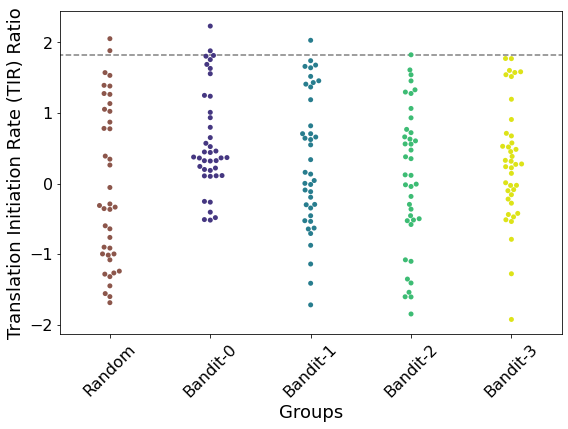

In [15]:
# for group in ['Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3']:
#     colors.append(color_dict[group])
# sns.set_palette(colors)
sns.set_palette(list(color_dict.values()))
# sns.set_palette(list(wcb_color_dict.values())[1:])

if plot_swarm_flag:
    f, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=False)
    sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df, ax = axes, order=['Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])
#     sns.swarmplot(x = 'Group2', y = 'AVERAGE', data = df, ax = axes, order=['Reference', 'Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])

    # y = df_e1[df_e1['Group'] == 'Consensus']['AVERAGE']
    # y = result_df['AVERAGE'].max()
    y = top10
    # axes.scatter(x = 0, y = y, color = color_dict['Consensus'])
    axes.plot([-1,9], [y,y], '--', color = 'grey')
    # axes.text(0, 1.06, 'BN')
    # axes.text(0, y + 0.05, 'SD')

    axes.set(xlabel='Groups', ylabel='Translation Initiation Rate (TIR) Ratio')
#     \n averaged over 6 technical replicates
#     axes.set_title('Swarmplot with TIR Labels (ratio)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(plot_path + 'swarmplot.pdf')

# Quantile plot

In [16]:

def quant_line(df, col = 'Group', title = 'Quantile of groups'):
    f, axes = plt.subplots(1, 1, figsize=(5, 6), sharex=False)
    quantile_levels = [0.9, 0.8, 0.7, 0.6, 0.5]
    used_groups = ['Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3']
    df_bandits = df.loc[df[col].isin(used_groups)]

    quant_dict = defaultdict(list)
    groups = df_bandits.groupby(col)
    

    for used_group in used_groups:
        quant_dict['max'].append(groups.get_group(used_group)['AVERAGE'].max())
    axes.plot(range(len(used_groups)), quant_dict['max'], marker = '.', linestyle = 'dashdot', markersize = 12, label = 'max', alpha = 0.8, color = 'orange')

    for quant in quantile_levels:
        for used_group in used_groups:
            quant_dict[quant].append(groups.get_group(used_group)['AVERAGE'].quantile(quant))
        axes.plot(range(len(used_groups)), quant_dict[quant], marker = '.', linestyle = 'dashdot', markersize = 12, label = str(quant) + ' Q', alpha = 0.8)
    print(quant_dict)
    # plt.plot(df_bandits.sort_values('AVERAGE',ascending=False).groupby(col).nth(4)['AVERAGE'], marker = '.', label = 'Top-5', alpha = 0.6)
    plt.legend(loc ='upper right', fontsize = 14) # , fontsize = 'small'
    axes.plot([0,5], [top10,top10], '--', color = 'grey')
    axes.set(xlabel='Groups', ylabel='Translation Initiation Rate (TIR) Ratio')
    plt.xticks(range(len(used_groups)), used_groups, rotation=45)
#     plt.title(title)
    plt.tight_layout()
    plt.savefig(plot_path + 'quantplot.pdf')

defaultdict(<class 'list'>, {'max': [2.0534206979480434, 2.2321816317389582, 2.0304966399227427, 1.8247855503052808, 1.7725163761554272], 0.9: [1.4061600752939745, 1.7616597138098635, 1.6428829179751316, 1.3411111100299344, 1.5749120901739075], 0.8: [1.159449564703064, 1.3109046277979983, 1.4132743723535734, 0.9577789385233281, 0.9653153261077343], 0.7: [0.8080156508075207, 0.8377531650518215, 0.7397891572696516, 0.6389581187874116, 0.5419505130721296], 0.6: [0.2953123546536183, 0.4856618548192986, 0.6307861442568994, 0.5080871018344256, 0.4119512466832962], 0.5: [-0.32308971157574606, 0.3717102791143315, 0.14621625045686198, 0.11957131851651309, 0.27419092429991165]})


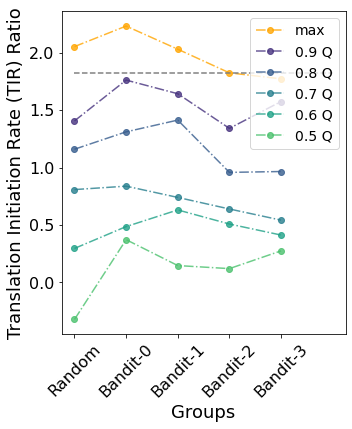

In [17]:
if plot_quant_flag:
    sns.set_palette('viridis') 
    quant_line(df, 'Group')
    

# TSNE plot

In [18]:
n_dim = 2

wds_kernel = WD_Shift_Kernel(l = 6, s=1)
distance = wds_kernel.distance(wds_kernel.kernel_all_normalised)

Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True


In [19]:
distance.shape

(400, 400)

In [20]:

# dim reduction
tsne = TSNE(n_components = n_dim, metric = 'precomputed', random_state = 5)
tsne_distance = tsne.fit_transform(distance)

In [21]:
with open('../data/idx_seq_lit.pickle', 'rb') as handle:
    idx_seq_dict = pickle.load(handle)['idx_seq_dict']

group_dict = defaultdict(list)
group_TIR_dict = defaultdict(list)
group_RBS6_dict = defaultdict(list)
known_seq = set(df['RBS'])
size = 120

for idx in range(distance.shape[0]):
    seq = idx_seq_dict[idx]
    if seq in known_seq:
        group = df.loc[df['RBS'] == seq, 'Group'].values[0]
        TIR = df.loc[df['RBS'] == seq, 'AVERAGE'].values[0]
        RBS6 = df.loc[df['RBS'] == seq, 'RBS6'].values[0]
        # print(group)
        group_dict[group].append(idx)
        group_TIR_dict[group].append(TIR * size)
        group_RBS6_dict[group].append(RBS6)
        # idx_color_dict[idx] = color_dict[str(group)]
        # color_list.append(color_dict[str(group)])
    else:
        group_dict['Unlabeled'].append(idx)
        group_TIR_dict['Unlabeled'].append(0.2 * size)
        group_RBS6_dict['Unlabeled'].append(idx_seq_dict[idx])


In [22]:
sns.set_palette(list(color_dict.values())[1:])

if plot_tsne_flag:
    rcParams['legend.fontsize'] = 10
    f, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=False)
    groups = ['Unlabeled', 'Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3']
#     groups = ['Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3', 'Reference', 'Unlabeled']
    for group in groups:
        idxes = np.asarray(group_dict[group])
        
        alpha = 0.5
      
        plt.scatter(tsne_distance[idxes,0], tsne_distance[idxes,1], alpha = alpha, color = color_dict[group],  s = group_TIR_dict[group][:], label = group)
#         edgecolors = 'none',
        
#         plt.plot(-2, 12, 'o',
#                 ms=28 * 2, mec='b', alpha = 0.6, mfc='none', mew=1)
#         plt.plot(-12,-4, 'o',
#                 ms=20 * 2, mec='b', alpha = 0.6, mfc='none', mew=1)
#         plt.plot(0,-16, 'o',
#                 ms=26 * 2, mec='b', alpha = 0.6, mfc='none', mew=1)
#         plt.annotate('G-Rich Clusters', xy=[-10, 15], xytext=(-120, 30),
#                     textcoords='offset points',
#                     color='b', size='large',
# #                     arrowprops=dict(
# #                         arrowstyle='simple,tail_width=0.3,head_width=0.8,head_length=0.8',
# #                         facecolor='b', shrinkB=39 * 1.2, alpha = 0.6)
#                     )
        plt.legend(loc = 'lower left')
        plt.xlabel('tSNE Dimension 1')
        plt.ylabel('tSNE Dimension 2')
#         plt.title('TSNE for RBS design space')
        plt.tight_layout()
#         plt.savefig(plot_path +'tsneplot.pdf')
        
rcParams['legend.fontsize'] = 13

In [23]:
# from adjustText import adjust_text

# x_range = [0,10]
# y_range = [-10,0]

x_range = [-5,5]
y_range = [5,15]

# x_range = [-10,0]
# y_range = [15,35]


if plot_tsne_flag:
    rcParams['legend.fontsize'] = 10
    f, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=False)
    groups = ['Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3']
#     groups = ['Bandit-3']
    for group in groups:
        idxes = np.asarray(group_dict[group])
        if group == 'Unlabeled':
            alpha = 0.05
        elif group == 'BPS-NC':
            alpha = 0.2
        elif group == 'Reference':
            alpha = 0.8
        else:
            alpha = 0.5
      
        plt.scatter(tsne_distance[idxes,0], tsne_distance[idxes,1], alpha = alpha, color = color_dict[group],  s = group_TIR_dict[group][:], label = group)
#         edgecolors = 'none',

        texts = []
        
        for i, idx in enumerate(idxes):
#             if tsne_distance[idx,0] >= -15 and tsne_distance[idx,0] <= 5 and tsne_distance[idx,1] >= -10 and tsne_distance[idx,1] <= 10 and group != 'Unlabeled':
            if tsne_distance[idx,0] >= x_range[0] and tsne_distance[idx,0] <= x_range[1] and tsne_distance[idx,1] >= y_range[0] and tsne_distance[idx,1] <= y_range[1] and group != 'Unlabeled':
                texts.append(plt.text(tsne_distance[idx,0], tsne_distance[idx,1], group_RBS6_dict[group][i]))
#         adjust_text(texts, x = tsne_distance[idxes,0], y = tsne_distance[idxes,1],  
#                     autoalign='y', force_points=0.1,
#                     only_move={'points':'y', 'text':'y'},
# #                     arrowprops=dict(arrowstyle="->", color='r')
#                    )
        
        plt.legend(loc = 'lower left')
        plt.xlabel('tSNE Dimension 1')
        plt.ylabel('tSNE Dimension 2')
        plt.xlim(x_range[0], x_range[1])
        plt.ylim(y_range[0], y_range[1])

#         plt.xlim(-15,5)
#         plt.ylim(-10,10)

#         plt.title('TSNE for RBS design space')
#         plt.tight_layout()
#         plt.savefig(plot_path +'tsneplot_zoomin.pdf')
        
rcParams['legend.fontsize'] = 13

# Histogram

In [24]:
def hist(df, title = 'Hist'):
    f, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=False)
    df = df.append({'Group': 'Bandit-2', 'AVERAGE' : -0.1}, ignore_index=True) # for kde range
    df_bandits = df.loc[df['Group'].isin(['Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])]
    sns.histplot(data = df_bandits, x = 'AVERAGE', binwidth = 0.1, 
    # binrange = [0, 1.4], 
    hue = 'Group', kde=True, 
                #  kde_kws ={'clip': [0,1.4]}, 
                 alpha = 0.5)
    # df_random = df[df['Group2'] == 'Random']
    # sns.histplot(data = df_random, x = 'AVERAGE', hue = 'Group2', kde=True, color = color_dict['Random'])
    axes.set(xlabel='Translation Initiation Rate (TIR) Ratio')
#     plt.title(title)
    # plt.xlim(0,1.4)
    plt.tight_layout()
    plt.savefig(plot_path +'histogram.pdf')
    print('mean:')
    print(df_bandits.groupby('Group').mean())
    print('0.9 quantile')
    print(df_bandits.groupby('Group').quantile(0.9))

mean:
          Unnamed: 0  pred mean  pred std       ucb       lcb  Round   AVERAGE
Group                                                                         
Bandit-0        59.5   0.938350  0.673088  2.284526 -0.407826    1.0  0.599135
Bandit-1        99.5   0.825196  0.453665  1.732527 -0.082134    2.0  0.312080
Bandit-2       139.5   0.588425  0.409081  1.406587 -0.229736    3.0  0.076379
Bandit-3       179.5   0.463050  0.331513  0.463050  0.463050    4.0  0.307994
0.9 quantile
          Unnamed: 0  pred mean  pred std       ucb       lcb  Round   AVERAGE
Group                                                                         
Bandit-0        75.1   1.366987  0.794371  2.618125  0.315302    1.0  1.761660
Bandit-1       115.1   1.243935  0.560022  2.044937  0.548639    2.0  1.642883
Bandit-2       155.1   0.977497  0.473789  1.751090  0.253569    3.0  1.328470
Bandit-3       195.1   0.725980  0.366485  0.725980  0.725980    4.0  1.574912


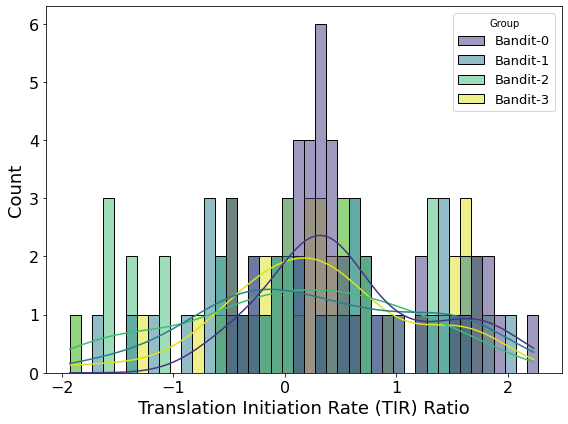

In [25]:
if plot_hist_flag:
#     sns.set_palette('viridis') 
    sns.set_palette(list(bandit_color_dict.values())) 
    hist(df, 'Histogram')

# Scatterplot

In [26]:
# copy from the pipeline for recommending round 2 seq
from src.batch_ucb import *
from src.regression import *
from scipy.stats import spearmanr

rec_size = 90
l = 6
s = 1
beta = 0
alpha = 2
sigma_0 = 1
kernel = 'WD_Kernel_Shift'
embedding = 'label'
kernel_norm_flag = True

sns.set_palette('tab10') 

In [27]:
def run_regression(df,kernel, embedding, predictor = GPR_Predictor, train_idx = None, test_idx = None, 
                    eva_metric = [mean_squared_error, r2_score], l = 6, s = 1, sigma_0=1, alpha = 2, 
                    eva_on='seqs', title = 'Prediction',
                    kernel_norm_flag = True, centering_flag = False, unit_norm_flag = True, kernel_over_all_flag = True):
    title = title + ' centering' + str(centering_flag) + 'unitnorm' + str(unit_norm_flag)
    # train and test on round 0
    gpr_train_samples = predictor(df, train_idx= train_idx, test_idx=test_idx, kernel_name = kernel,
                kernel_norm_flag = kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag = unit_norm_flag, kernel_over_all_flag = kernel_over_all_flag,
                embedding = embedding, eva_metric = eva_metric, l = l, s = s, sigma_0 = sigma_0, alpha = alpha, eva_on=eva_on)
    gpr_train_samples.regression(random_state = 0)

    return gpr_train_samples
    # gpr_train_samples.scatter_plot(title = title)

In [28]:
def scatter_plot(predictor_list, title, plot_title = 'Prediction'):
        """Scatter plot for predictions.
        x-axis: label
        y-axis: prediction
        """
        # fig, axes = plt.subplots(1,4, figsize = (20,6))
        fig, axes = plt.subplots(2,2, figsize = (12,12))
        for i, predictor in enumerate(predictor_list):
            if predictor.eva_on == 'samples':
                eva_column = 'label'
            else:
                eva_column = 'AVERAGE'

            # if eva_column == 'AVERAGE': # debug
            #     self.train_df = self.train_df[self.train_df['variable'] == 'Rep1']
            print('#################################')
            print('  Evaluation  ', title[i])
            print('#################################')
            for metric in predictor.eva_metric:
                print(str(metric))
                print('Train: ', metric(predictor.train_df[eva_column], predictor.train_df['pred mean']))
                print('Test: ', metric(predictor.test_df[eva_column], predictor.test_df['pred mean']))

            print('spearman cor:')
            print('Train: ', spearmanr(predictor.train_df[eva_column], predictor.train_df['pred mean']))
            test_spearmanr = spearmanr(predictor.test_df[eva_column], predictor.test_df['pred mean'])
            print('Test: ', test_spearmanr.correlation, ' ', test_spearmanr.pvalue)

            # report slope
            test_pred_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['pred mean'],deg=1)
            test_ave_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['AVERAGE'],deg=1)
            print('Test pred fit: ', test_pred_fit)
            print('Test ave fit: ', test_ave_fit)
            
            if 'pred std' in predictor.test_df:
                print('coverage rate: ')
                print('Train: ',  predictor.coverage_rate(predictor.train_df[eva_column], predictor.train_df['pred mean'], predictor.train_df['pred std']))
                print('Test: ',  predictor.coverage_rate(predictor.test_df[eva_column], predictor.test_df['pred mean'], predictor.test_df['pred std']))

            if i < 2:
                row = 0
            else:
                row = 1

            axes[row, i % 2].scatter(predictor.train_df[eva_column], predictor.train_df['pred mean'], label = 'train', alpha = 0.2)
            axes[row, i % 2].scatter(predictor.test_df[eva_column], predictor.test_df['pred mean'], label = 'test', alpha = 0.8)
            axes[row, i % 2].set_xlabel('True TIR')
            axes[row, i % 2].set_ylabel('Predict TIR')
            axes[row, i % 2].legend()
            axes[row, i % 2].plot([-2, 3], [-2,3], '--', color = 'black', alpha = 0.5)
            axes[row, i % 2].set_title('\n' + title[i] + 
                '\n R2 = ' + str("{:.3f}".format(r2_score(predictor.test_df[eva_column], predictor.test_df['pred mean']))) + 
                '\n Spearman cor = ' + str("{:.3f}".format(test_spearmanr.correlation)) + ' pvalue: ' + str("{:.2e}".format(test_spearmanr.pvalue))
                )

#         fig.suptitle(plot_title, size = 16, y = 0.98)
        fig.tight_layout()
#         fig.subplots_adjust(top=0.85)
        fig.savefig(plot_path + 'scatter_' + valid_path(plot_title) + '.pdf')

In [29]:
def scatter_plot_single(predictor_list, title, plot_title = 'Prediction', save_to = ''):
        """Scatter plot for predictions.
        x-axis: label
        y-axis: prediction
        """
        # fig, axes = plt.subplots(1,4, figsize = (20,6))
        sns.set_palette('tab10') 
        
        for i, predictor in enumerate(predictor_list):
            if predictor.eva_on == 'samples':
                eva_column = 'label'
            else:
                eva_column = 'AVERAGE'

            # if eva_column == 'AVERAGE': # debug
            #     self.train_df = self.train_df[self.train_df['variable'] == 'Rep1']
            print('#################################')
            print('  Evaluation  ', title[i])
            print('#################################')
            for metric in predictor.eva_metric:
                print(str(metric))
                print('Train: ', metric(predictor.train_df[eva_column], predictor.train_df['pred mean']))
                print('Test: ', metric(predictor.test_df[eva_column], predictor.test_df['pred mean']))

            print('spearman cor:')
            print('Train: ', spearmanr(predictor.train_df[eva_column], predictor.train_df['pred mean']))
            test_spearmanr = spearmanr(predictor.test_df[eva_column], predictor.test_df['pred mean'])
            print('Test: ', test_spearmanr.correlation, ' ', test_spearmanr.pvalue)

            # report slope
            test_pred_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['pred mean'],deg=1)
            test_ave_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['AVERAGE'],deg=1)
            print('Test pred fit: ', test_pred_fit)
            print('Test ave fit: ', test_ave_fit)
            
            if 'pred std' in predictor.test_df:
                print('coverage rate: ')
                print('Train: ',  predictor.coverage_rate(predictor.train_df[eva_column], predictor.train_df['pred mean'], predictor.train_df['pred std']))
                print('Test: ',  predictor.coverage_rate(predictor.test_df[eva_column], predictor.test_df['pred mean'], predictor.test_df['pred std']))

            fig, axes = plt.subplots(1,1, figsize = (6,6))

            axes.scatter(predictor.train_df[eva_column], predictor.train_df['pred mean'], label = 'train', alpha = 0.2)
            axes.scatter(predictor.test_df[eva_column], predictor.test_df['pred mean'], label = 'test', alpha = 0.8)
            axes.set_xlabel('True TIR')
            axes.set_ylabel('Predict TIR')
            axes.legend()
            axes.plot([-2, 3], [-2,3], '--', color = 'black', alpha = 0.5)
            axes.set_title('\n' + title[i] + 
                '\n R2 = ' + str("{:.3f}".format(r2_score(predictor.test_df[eva_column], predictor.test_df['pred mean']))) + 
                '\n Spearman cor = ' + str("{:.3f}".format(test_spearmanr.correlation)) + ' pvalue: ' + str("{:.2e}".format(test_spearmanr.pvalue))
                )

#           fig.suptitle(plot_title, size = 16, y = 0.98)
            fig.tight_layout()
    #       fig.subplots_adjust(top=0.85)
            fig.savefig(save_to + 'scatter_' + valid_path(plot_title) + '_' + str(i) + '.pdf')

In [30]:
def generate_predictors(df, kernel, embedding, kernel_norm_flag = True, centering_flag = True, unit_norm_flag = True, kernel_over_all_flag = True):
    predictors = []
    for i in range(1,5):
        title = 'Train < ' + str(i)+ ' and Test ' + str(i)
        predictor = run_regression(df, kernel, embedding, train_idx = df['Round'] < i, test_idx = df['Round'] == i, title = title, centering_flag=centering_flag, unit_norm_flag=unit_norm_flag, kernel_over_all_flag = kernel_over_all_flag)
        predictors.append(predictor)

    predictor = run_regression(df, kernel, embedding, title = 'Train and Test on All Rounds', centering_flag=centering_flag, unit_norm_flag=unit_norm_flag, kernel_over_all_flag = kernel_over_all_flag)
    predictors.append(predictor)
    return predictors
    

In [31]:
result_path = '../data/Results_Lit.csv'
data_df = pd.read_csv(result_path, header = 0)
data_df

,Name,Group,Plate,Round,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,NaN,NaN,10,AACGGAGTCGGCGGAGGAGG,ACTCCGGGAG,-1.343078,-1.262407,-1.579078,-1.977176,-1.632812,-1.179222,-1.305994,0.3
1,1,NaN,NaN,10,AACGGAGTCGGAAGAGGATG,ACTCAAGGAT,-1.371116,-1.445593,-1.402465,-1.296466,-1.455024,-1.434666,-1.479594,0.3
2,2,NaN,NaN,10,AACGGAGTCGGTCGAGCGAG,ACTCTCGCGA,-1.779223,-1.372477,-2.075577,-2.016623,-1.658551,-1.419108,-1.579333,0.3
3,3,NaN,NaN,10,AACGGAGTCGGCTAAGAAGG,ACTCCTAAAG,-1.392234,-0.771739,-1.682233,-1.174715,-1.390824,-0.732740,-1.335501,0.3
4,4,NaN,NaN,10,ATAGGAGGAGGCGGAGGAGG,TAGACGGGAG,0.602791,0.480145,0.435208,0.176507,0.567176,0.366093,0.440110,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,NaN,NaN,10,AGGGGAGAGGGCTGAGAGCG,GGAGCTGAGC,-0.774793,-1.479810,-1.081520,-1.288052,-1.536570,-0.774591,-0.860324,0.3
396,396,NaN,NaN,10,AGGGGAGAGGGCTAAGAGAG,GGAGCTAAGA,-0.036174,-0.664157,-0.482374,-0.848080,-0.857045,-0.333456,-0.439222,0.3
397,397,NaN,NaN,10,AGGGGAGAGGGTGGAGGTAG,GGAGTGGGTA,-0.554211,-1.188147,-0.988946,-1.062345,-1.247581,-1.255105,-1.414302,0.3
398,398,NaN,NaN,10,AGGGGAGAGGGAAGAGTGAG,GGAGAAGTGA,-0.781112,-0.911330,-1.233167,-0.942434,-0.313119,-0.891782,-0.913297,0.3


In [32]:
df_merge = df[['RBS', 'RBS6', 'Group', 'Round']].merge(data_df[['RBS', 'Rep1', 'Rep2','Rep3','Rep4','Rep5','Rep6','AVERAGE','STD']])

In [33]:
if plot_scatter_flag:
    centering_flag = True
    unit_norm_flag = True
    df['STD'] = None
    df_abc1_TT_predictors = generate_predictors(df_merge, kernel, embedding, kernel_norm_flag = True, centering_flag = centering_flag, unit_norm_flag = unit_norm_flag)

X train shape:  (240, 20)
X test shape:  (40, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
gp_reg pred
finish reg
X train shape:  (480, 20)
X test shape:  (40, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
gp_reg pred
finish reg
X train shape:  (720, 20)
X test shape:  (40, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
gp_reg pred
finish reg
X train shape:  (960, 20)
X test shape:  (40, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True

#################################
  Evaluation   Train Round 0; Test Round 1
#################################
<function mean_squared_error at 0x7fb7bca90310>
Train:  0.4158495729455961
Test:  0.8115502426935723
<function r2_score at 0x7fb7bca90790>
Train:  0.6644131698241622
Test:  -0.5362862193480551
spearman cor:
Train:  SpearmanrResult(correlation=0.8459111239073698, pvalue=6.442006367385485e-67)
Test:  -0.07373358348968106   0.6511529265915625
Test pred fit:  [-0.00220929  0.98143128]
Test ave fit:  [ 0.06039803 -0.57862636]
coverage rate: 
Train:  0.825
Test:  0.925
#################################
  Evaluation   Train Round 0-1; Test Round 2
#################################
<function mean_squared_error at 0x7fb7bca90310>
Train:  0.41540413413617755
Test:  1.0675302290894297
<function r2_score at 0x7fb7bca90790>
Train:  0.5802123452996326
Test:  -0.18243881672463336
spearman cor:
Train:  SpearmanrResult(correlation=0.7827941865916549, pvalue=1.560435345618344e-100)
Test:  0.326

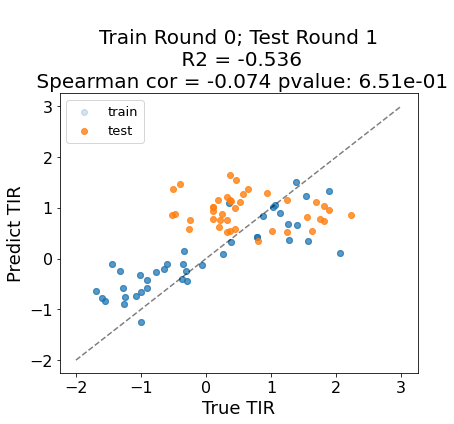

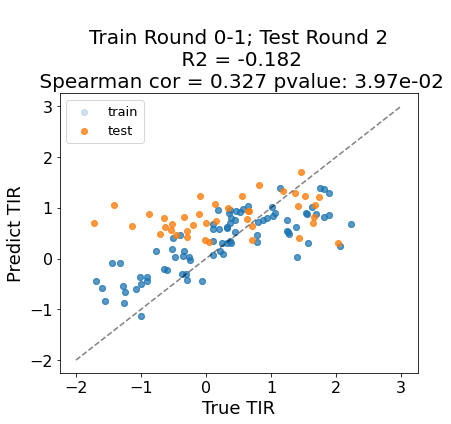

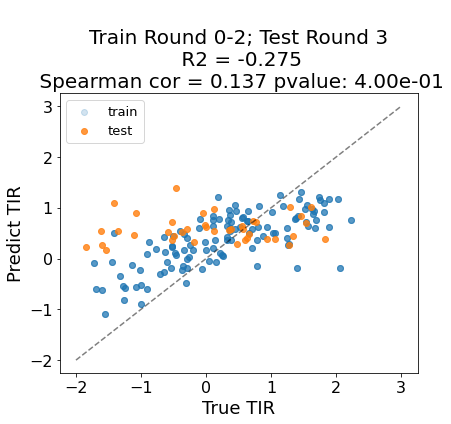

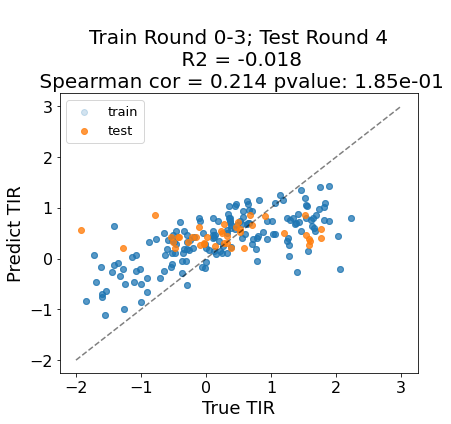

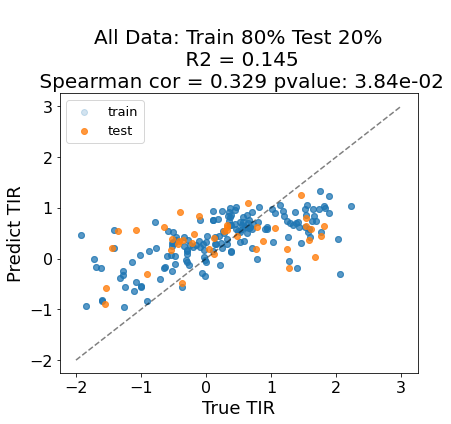

In [34]:
sns.set_palette('tab10') 
if plot_scatter_flag:
    scatter_plot_single(df_abc1_TT_predictors, 
                ['Train Round 0; Test Round 1', 'Train Round 0-1; Test Round 2', 'Train Round 0-2; Test Round 3', 'Train Round 0-3; Test Round 4', 'All Data: Train 80% Test 20%'], 'abc1 TT', save_to = plot_path_supp)

In [35]:
if plot_scatter_flag:
    centering_flag = False
    unit_norm_flag = False

    df_abc1_FF_predictors = generate_predictors(df_merge, kernel, embedding, kernel_norm_flag = True, centering_flag = centering_flag, unit_norm_flag = unit_norm_flag)

X train shape:  (240, 20)
X test shape:  (40, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
gp_reg pred
finish reg
X train shape:  (480, 20)
X test shape:  (40, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
gp_reg pred
finish reg
X train shape:  (720, 20)
X test shape:  (40, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
gp_reg pred
finish reg
X train shape:  (960, 20)
X test shape:  (40, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_

#################################
  Evaluation   Train Round 0; Test Round 1
#################################
<function mean_squared_error at 0x7fb7bca90310>
Train:  0.4904101513090504
Test:  0.8101457334897468
<function r2_score at 0x7fb7bca90790>
Train:  0.6042434599652988
Test:  -0.5336274460259955
spearman cor:
Train:  SpearmanrResult(correlation=0.834100699303065, pvalue=1.9954879973783694e-63)
Test:  -0.1127579737335835   0.48846990389615275
Test pred fit:  [-0.00350997  0.46904582]
Test ave fit:  [ 0.06039803 -0.57862636]
coverage rate: 
Train:  0.725
Test:  0.725
#################################
  Evaluation   Train Round 0-1; Test Round 2
#################################
<function mean_squared_error at 0x7fb7bca90310>
Train:  0.44999376718570566
Test:  0.8760221653479224
<function r2_score at 0x7fb7bca90790>
Train:  0.5452577077753761
Test:  0.029683109299780575
spearman cor:
Train:  SpearmanrResult(correlation=0.7589310829817157, pvalue=4.239871981703714e-91)
Test:  0.2866

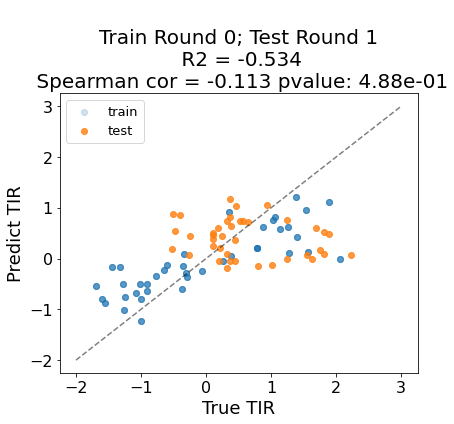

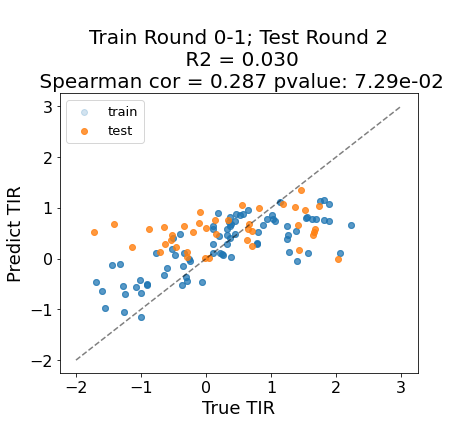

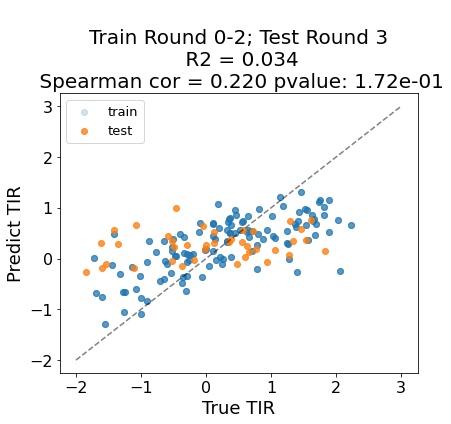

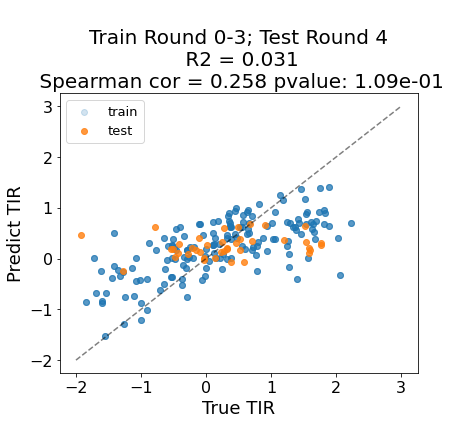

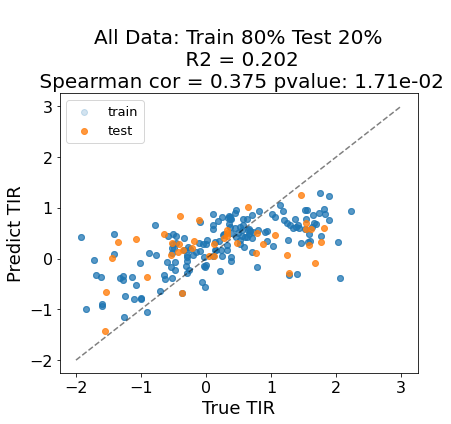

In [36]:
if plot_scatter_flag:
    
    scatter_plot_single(df_abc1_FF_predictors, 
                ['Train Round 0; Test Round 1', 'Train Round 0-1; Test Round 2', 'Train Round 0-2; Test Round 3', 'Train Round 0-3; Test Round 4', 'All Data: Train 80% Test 20%'], 'abc1 FF', save_to=plot_path)

# Exploration v.s. Exploitation  

In [37]:
# Exploration v.s. Exploitation  
# projection 

# p1 = np.asarray([0,1])
# p2 = np.asarray([1,0])
# p3 = np.asarray([1,1])

def proj(to_proj_list, p1 = np.asarray([0,2]), p2 = np.asarray([2,0])):
    projections = []
    l2 = np.sum((p1-p2)**2)

    for p3 in to_proj_list:
#         t = max(0, min(1, np.sum((p3 - p1) * (p2 - p1)) / l2))
        t = np.sum((p3 - p1) * (p2 - p1)) / l2
        projection = p1 + t * (p2 - p1)

        projections.append(projection)
    
    return np.asarray(projections)

def mean_vs_var_plot(predictor_list, title, plot_title = 'Prediction'):
    """Scatter plot for predictions.
    x-axis: label
    y-axis: prediction
    """
    # fig, axes = plt.subplots(1,4, figsize = (20,6))
    
    proj_df_list = []
    for i, predictor in enumerate(predictor_list[:4]):


        if i < 2:
            row = 0
        else:
            row = 1

        projections = proj(np.asarray(predictor.test_df[['pred mean', 'pred std']]))
        print(i)
        print('Round: ', predictor.test_df['Round'].unique())
        test_df = predictor.test_df.copy()
        test_df['proj0'] = projections[:,0]
        # test_df['proj0'] = predictor.test_df['pred mean']/predictor.test_df['pred std']
        proj_df_list.append(test_df)

#             axes[row, i % 2].scatter(predictor.train_df['pred mean'], predictor.train_df['pred std'], label = 'train', alpha = 0.2)
        
        fig, axes = plt.subplots(1,1, figsize = (6,6))
        axes.scatter(predictor.test_df['pred mean'], predictor.test_df['pred std'], label = 'test', alpha = 0.8, color = tab10.colors[2])
        sns.set_palette('RdBu') 
        axes.scatter(projections[:,0], projections[:,1], label = 'projections', c = projections[:,0], cmap = 'RdBu')
        axes.set_ylabel('Predict STD')
        axes.set_xlabel('Predict TIR')
        axes.legend()
        axes.plot([0, 2], [2,0], '--', color = 'black', alpha = 0.5)
        axes.set_title('\n' + title[i]                  
#                  + '\n R2 = ' + str("{:.3f}".format(r2_score(predictor.test_df[eva_column], predictor.test_df['pred mean']))) + 
#                 '\n Spearman cor = ' + str("{:.3f}".format(test_spearmanr.correlation)) + ' pvalue: ' + str("{:.2e}".format(test_spearmanr.pvalue))
            )
        axes.set_xlim(-0.5,2.5)   
        axes.set_ylim(-0.5,2.5) 
#         fig.suptitle(plot_title, size = 16, y = 0.98)
        fig.tight_layout()
    #         fig.subplots_adjust(top=0.85)
        fig.savefig(plot_path_supp + 'proj_scatter_' + valid_path(plot_title) + '_' + str(i) + '.pdf')
    return proj_df_list

0
Round:  [1]
1
Round:  [2]
2
Round:  [3]
3
Round:  [4]


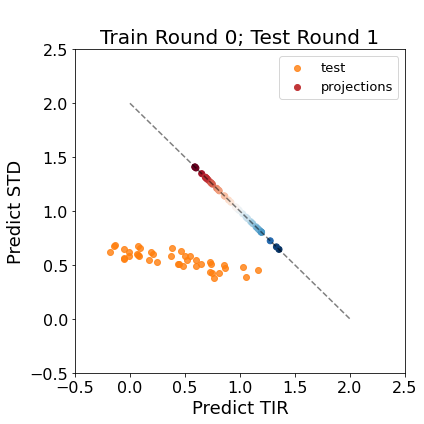

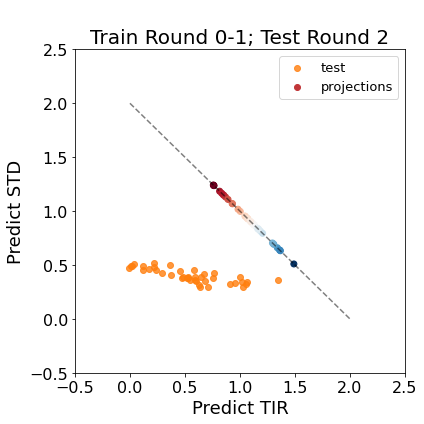

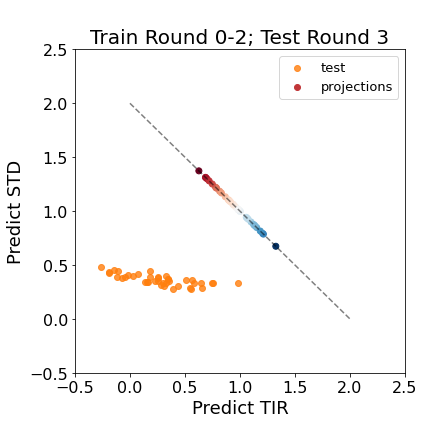

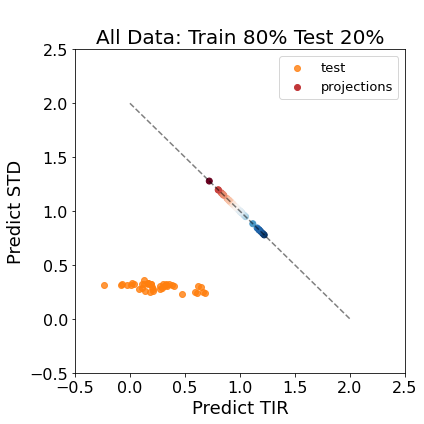

In [38]:
sns.set_palette('tab10') 
proj_df_list = mean_vs_var_plot(df_abc1_FF_predictors, 
                ['Train Round 0; Test Round 1', 'Train Round 0-1; Test Round 2', 'Train Round 0-2; Test Round 3', 'All Data: Train 80% Test 20%'], 'abc1 FF')

In [39]:
proj_df = pd.concat(proj_df_list)[['RBS', 'proj0']]
# [['Name', 'RBS', 'proj0']]
df_proj = df[df['Round'] > 0].merge(proj_df, on = 'RBS')

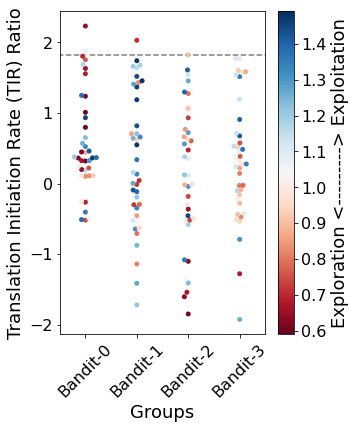

In [40]:
import matplotlib.pyplot as plt
import matplotlib.colorbar
import matplotlib.colors
import matplotlib.cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

if plot_swarm_flag:
    fig, axes = plt.subplots(1, 1, figsize=(5, 6), sharex=False)
        
    sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_proj, ax = axes, order=['Bandit-0', 'Bandit-1', 'Bandit-2','Bandit-3'], hue = 'proj0', palette = 'RdBu')
#     sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_e1_proj, ax = axes, order=['Bandit-1', 'Bandit-2', 'Bandit-3'], hue = 'proj0', palette = colors)
    norm = plt.Normalize(df_proj['proj0'].min(), df_proj['proj0'].max())
    sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
    sm.set_array([])

    axes.get_legend().remove()
    cb = axes.figure.colorbar(sm)
    cb.set_label('Exploration <---------> Exploitation')
    #     y = df_e1[df_e1['Group'] == 'Consensus']['AVERAGE']
#     axes.scatter(x = 0, y = y, color = color_dict['Consensus'])
    axes.plot([-1,9], [top10,top10], '--', color = 'grey')
#     axes.text(0, y + 0.05, 'SD')
    axes.set(xlabel='Groups', ylabel='Translation Initiation Rate (TIR) Ratio')
#     axes.set_title('Swarmplot with TIR Labels (ratio)')
    plt.legend([],[], frameon=False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(plot_path + 'swarmplot_proj.pdf')